In [1]:
import imageio as im
import numpy as np
import matplotlib.pyplot as plt
import os

# Analysis of the images
The images that must be stitched together form the following grid

In [2]:
base_dir = 'sequencia_1/'
image_names = sorted(os.listdir(base_dir))[1:]
images = list(map(lambda name: im.imread(f'{base_dir}{name}'), image_names))

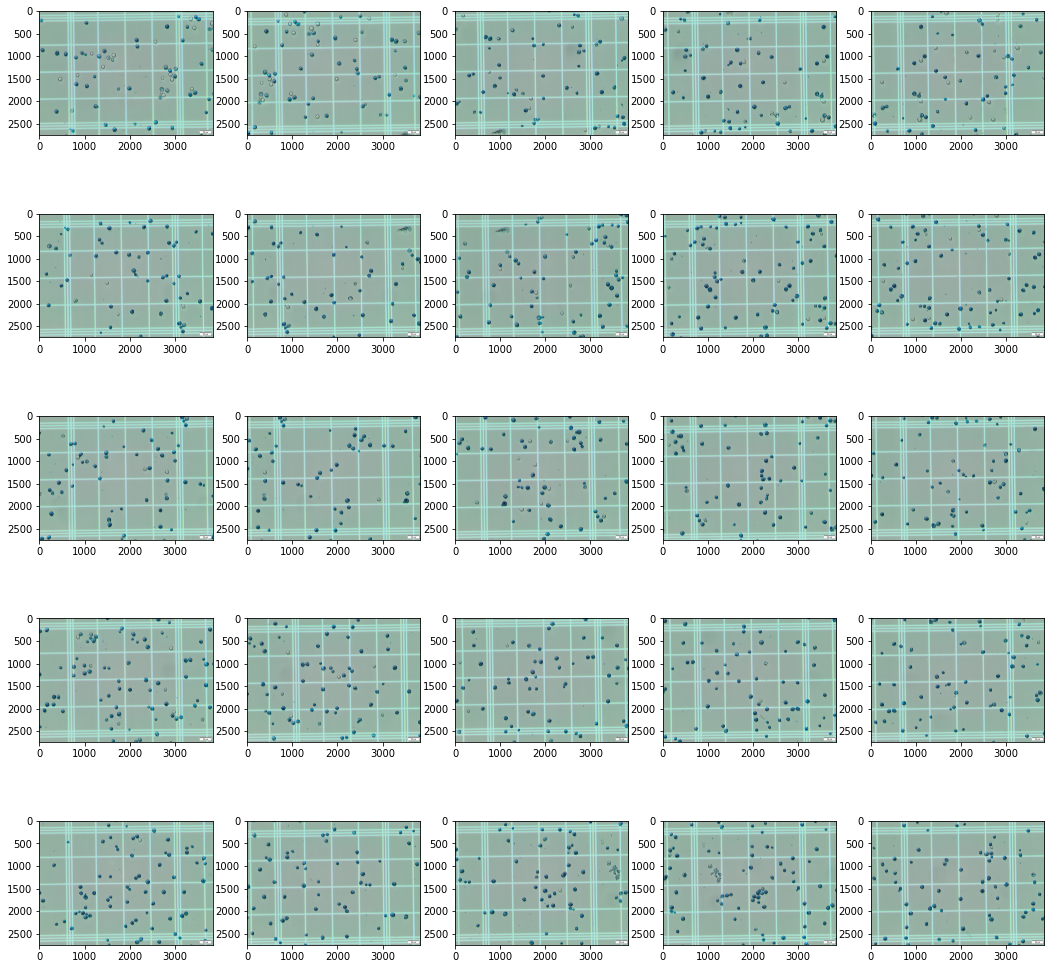

In [3]:
fig, axis = plt.subplots(5, 5, figsize=(18, 18))
for img, ax in zip(images, np.ravel(axis)):
    ax.imshow(img)

From this simple visual analysis, we can see that detecting keypoints through 
either blob or edge detection would be really dificult, there are no particularly
unique points in those images. That being the case, it is best to ignore the 
content of the images themselves and just look at the background grid to compute
the transformations that can be used to merge all images into a single one 
with minimum overlap. Thus, thresholding is going to be applied to each image 
for the purpose of isolating the grid as a binary image.

# Thresholding

Before the thresholding is applied, the images need to be downsampled, otherwise
the computational cost will be too big with the current resolutions.

In [4]:
from stitching.transformations import downsample_img

downsampled = list(map(lambda img: downsample_img(img, 10), images))

In [5]:
print(downsampled[0].shape)

(274, 384, 3)


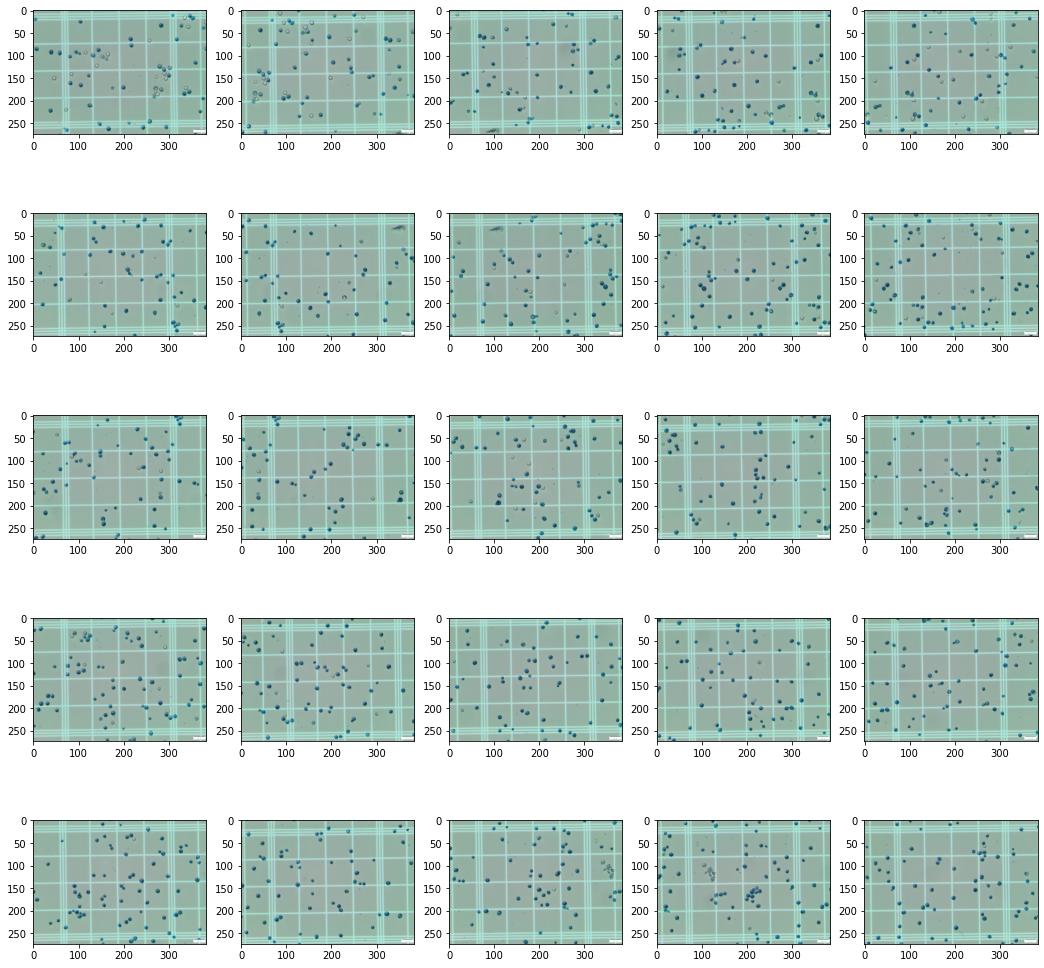

In [6]:
fig, axis = plt.subplots(5, 5, figsize=(18, 18))
for img, ax in zip(downsampled, np.ravel(axis)):
    ax.imshow(img)

After performing this downsampling, the images are converted from rgb to 
a grayscale and its color histograms are analyzed

In [7]:
from stitching.transformations import rgb_to_monochromatic
gray_scaled = list(map(rgb_to_monochromatic, downsampled))

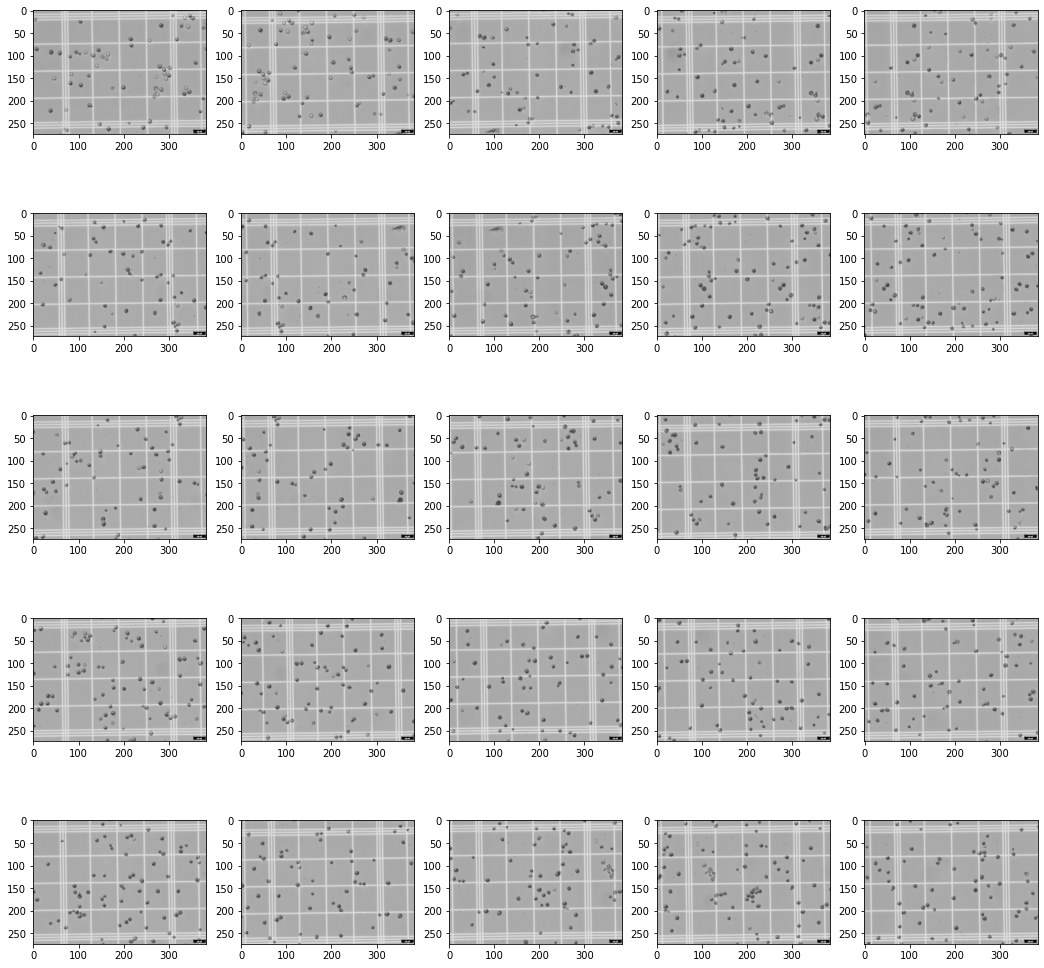

In [8]:
fig, axis = plt.subplots(5, 5, figsize=(18, 18))
for img, ax in zip(gray_scaled, np.ravel(axis)):
    ax.imshow(img, cmap='gray')

In [9]:
raveled = np.ravel(gray_scaled)
freqs, bins = np.histogram(raveled, bins=int(np.max(raveled)), density=True)

<BarContainer object of 255 artists>

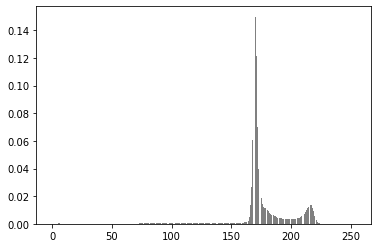

In [10]:
plt.bar(bins[:-1], freqs, color='gray')

With this histogram, it can be seen that since the grid has the brightest color in the monochromatic image, its gray level is probably within the following interval:

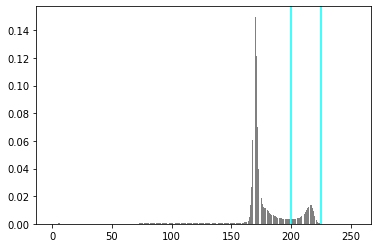

In [11]:
plt.bar(bins[:-1], freqs, color='gray')
plt.axvline(200, color='cyan')
plt.axvline(225, color='cyan')

To find the probability associated with this interval, we compute the cumulative
histogram and obtain the following percentile as a threshold

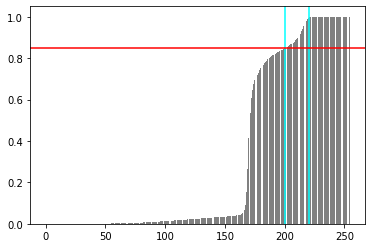

In [12]:
plt.bar(bins[:-1], list(np.add.accumulate(freqs) / np.sum(freqs)), color='gray')
plt.axvline(200, color='cyan')
plt.axvline(220, color='cyan')
plt.axhline(y=0.85, color='red')

Now, thresholding the images to values higher than the 85th percentile results in

In [13]:
from stitching.transformations import threshold
thresholded = list(map(lambda img: threshold(img, 0.85), gray_scaled))

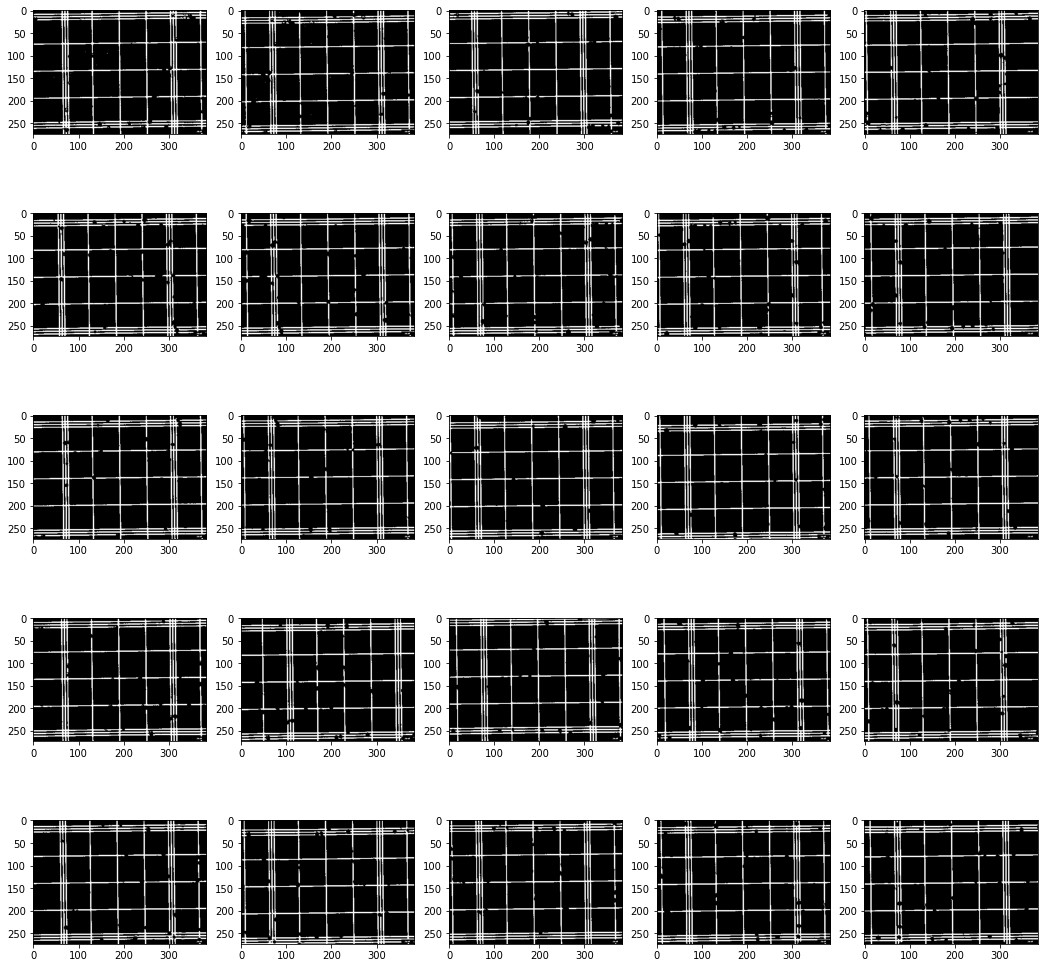

In [14]:
fig, axis = plt.subplots(5, 5, figsize=(18, 18))
for img, ax in zip(thresholded, np.ravel(axis)):
    ax.imshow(img, cmap='gray')

Which properly isolates the grid. But with a closer inspection, we can see that
it ends up leaving a good number of imperfections on the grid lines

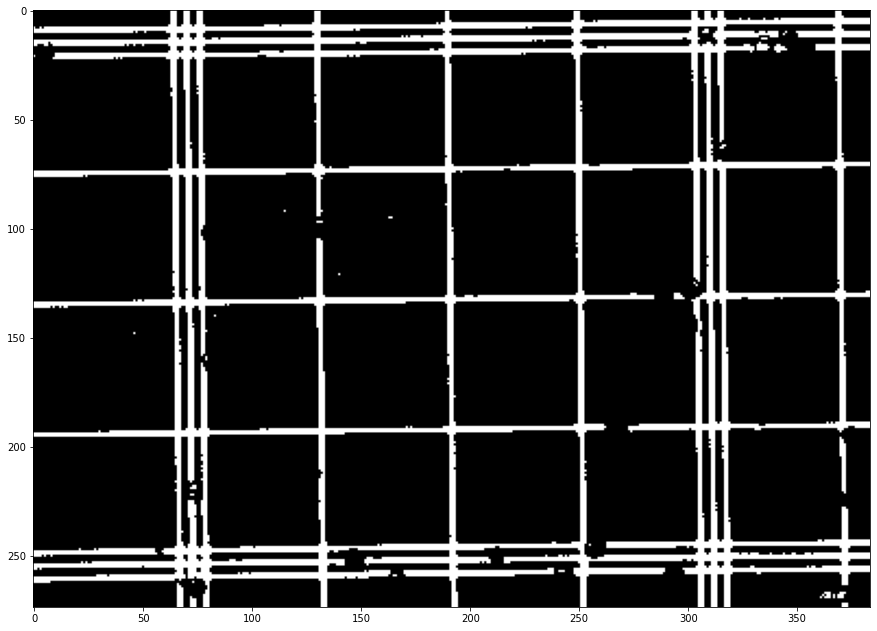

In [15]:
fig, axis = plt.subplots(1, figsize=(15, 15))
plt.imshow(thresholded[0], cmap='gray')

# Correcting rotation
Now that the grid has been isolated, we have that the textura along its rows
$f_i$ can described through the maximum probability value $\max_\{P_{f_i}\}$
in its color histogram $P_{f_i}$, or in other words, the measure of how much
participation the dominant color has in the row. We also have that the distance
between any two row texture descriptors $P_g$ and $P_h$ can be calculated as
$$|P_g - P_h|.$$ 

When a grid horizontal $P_i$ line is perfectly aligned with the axis, the dominant
color of the rows that represent it should have a histogram with a probability
of each pixel in that row having value one very close to the maximum. For rows
that do not represent horizontal lines, in an ideal thresholded grid image,
there should be a negligeble probability $c$ that a pixel has value zero 
(part of a vertical line) and a probability $1 - c$ that a pixel has value one.

In this case, $P_i - P_g$ will be positive for any rotated lien and approximately
0 otherwise. This makes this distance function almost linear, so $c$ is ignored,
and the row texture descriptor of an ideal thresholded grid image that is aligned
with the xy-axis is defined as row in which the color histogram has a maximum
probability value of one. Now using this row texture as a reference point, we
minimize the sum of the distances between the row textures of an image and the
row textures of an ideal grid through iterative rotations to obtain an estimator
of the angle that must be used by a rotation to align the image lines to the x axis. 

In [16]:
from scipy.optimize import minimize_scalar
from scipy.ndimage import rotate

def binary_value_max_probability(array):
    probability_of_1 = np.sum(array) / np.prod(array.shape)
    return max(probability_of_1, 1 - probability_of_1)

def loss_function(img):
    row_max_probabilites = [binary_value_max_probability(row) for row in img]
    return img.shape[0] - np.sum(row_max_probabilites)

def correct_image_rotation_angle(img):
    def rotation(ang):
        return loss_function(rotate(img, angle=ang))
    result = minimize_scalar(rotation, tol=1e-8)
    return result.x

In [17]:
angles = list(map(correct_image_rotation_angle, thresholded))

In [18]:
from itertools import starmap

def configured_rotation(img, angle):
    return rotate(img, angle, mode='reflect', reshape=False)

rotation_corrected = list(starmap(configured_rotation, zip(gray_scaled, angles)))

From that, the following results are obtained

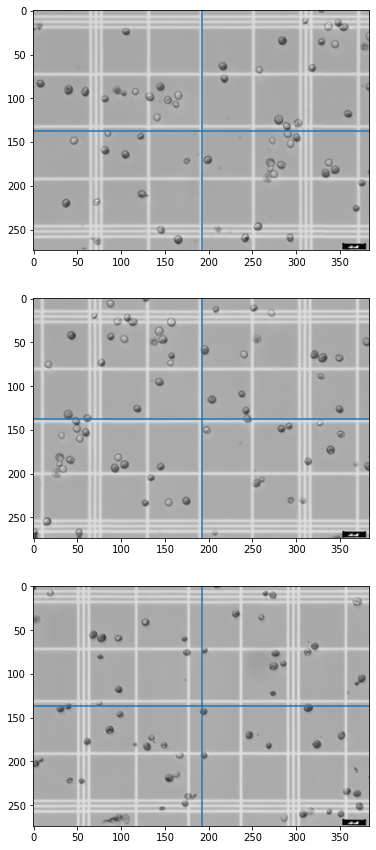

In [19]:
fig, axis = plt.subplots(3, figsize=(15, 15))
for img, ax in zip(rotation_corrected[:3], np.ravel(axis)[:3]):
    ax.imshow(img, cmap='gray')
    ax.axhline(img.shape[0] // 2)
    ax.axvline(img.shape[1] // 2)

# Key points detection

Now, for the key points detection, since the images don't have a lot of 
distinguishing features, the idea is to use the grid to detect the points 
that can be matched to the adjacent images, more precisely, the four groups of
three lines that are very close together can be used to estimate four corner
points on the image that can be matched to other images through ther spatial 
positions on the images. 

To find those points, we must first blurr the image so that the three lines that
are close together get merged into a single rectangle. For that a gaussian 
filter is applyed before thresholding for a lower percentile

In [20]:
from stitching.filters import apply_gaussian_filter

blurred = map(lambda img: apply_gaussian_filter(img, 3), rotation_corrected)
thresholded = list(map(lambda img: threshold(img, 0.7), blurred))

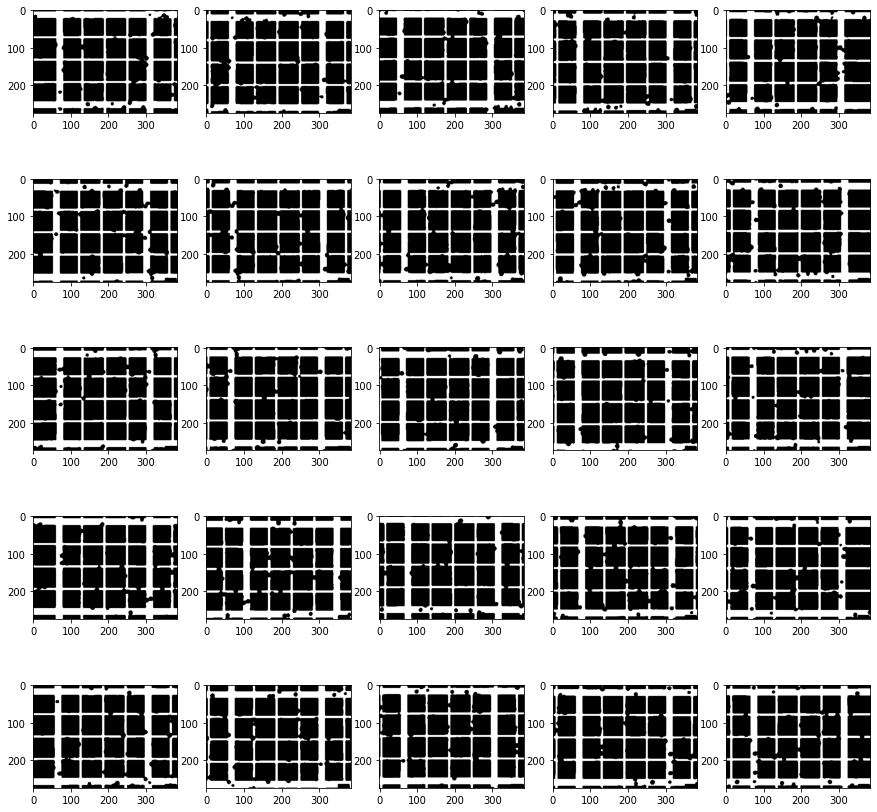

In [21]:
fig, axis = plt.subplots(5,5, figsize=(15, 15))
for img, ax in zip(thresholded, np.ravel(axis)):
    ax.imshow(img, cmap='gray')

Now, thresholding the row and column percentages of white pixels to detect lines,
we can find the two biggest areas of rows of the image filled with white pixels and
estimate their centers. The same thing can be done for the image columns. After
detecting those centers, their intersections give a very good estimate of the
corners of the central big square

In [22]:
from stitching.stitching import find_major_grid_corners

corners = list(map(find_major_grid_corners, thresholded))

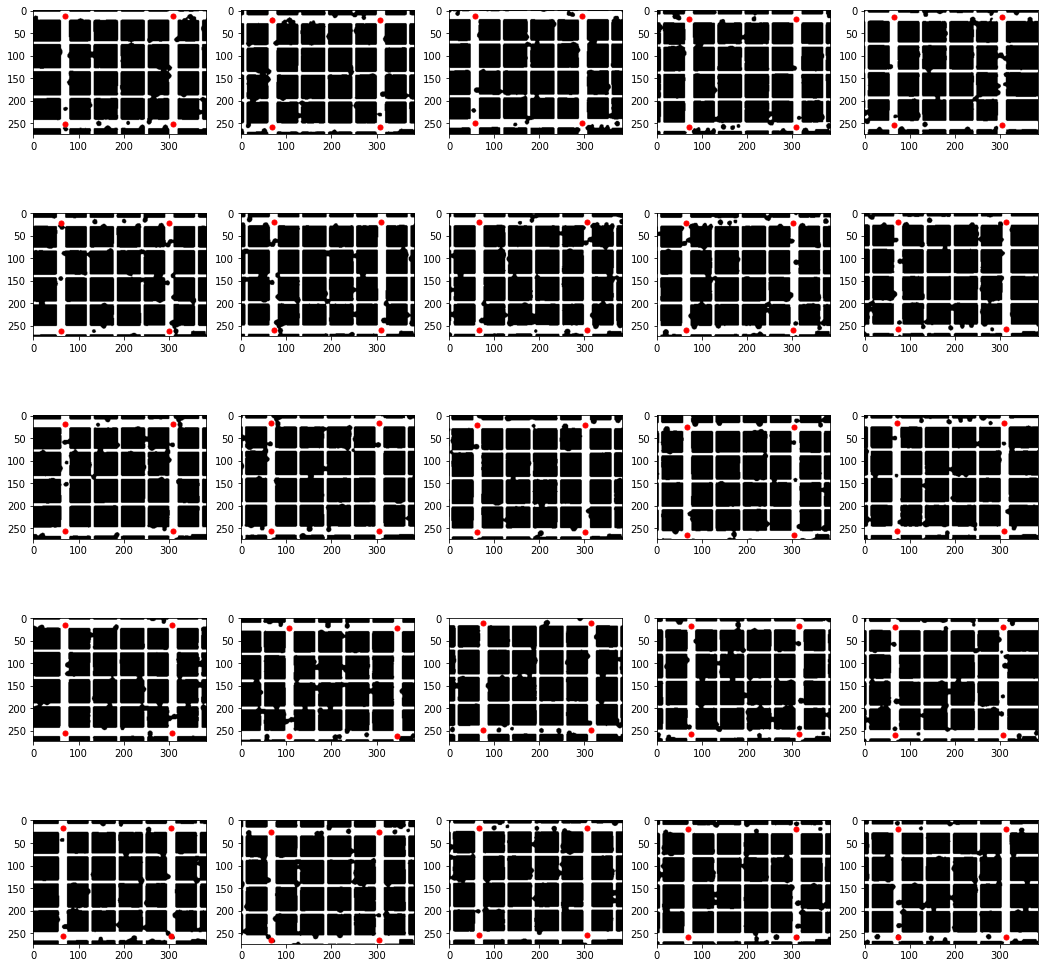

In [23]:
fig, axis = plt.subplots(5,5, figsize=(18, 18))
for img, ax, corn in zip(thresholded, np.ravel(axis), corners):
    x, y = zip(*np.vstack(corn))
    ax.imshow(img, cmap='gray')
    ax.plot(y, x, color='red', marker='o', linestyle='None', markersize=5)

Then computing the transformations that allow us to stitch them together, we
obtain the following results

In [24]:
from stitching.stitching import stitch_images
img_grid = [
    downsampled[:5],
    downsampled[5:10],
    downsampled[10:15],
    downsampled[15:20],
    downsampled[20:25],
]
result = stitch_images(img_grid)

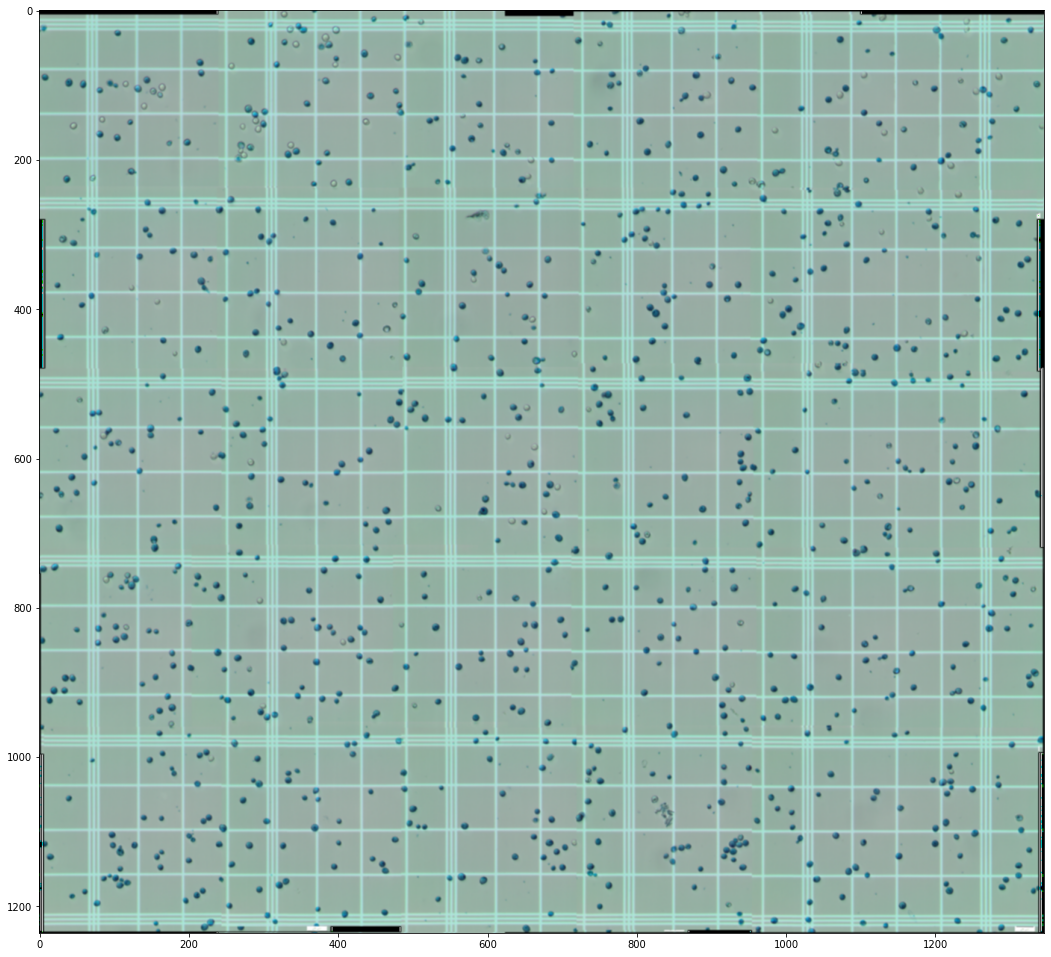

In [26]:
fig, axis = plt.subplots(1, figsize=(18, 18))
axis.imshow(apply_gaussian_filter(result))